In [1]:
# IMPORTS
import cvxpy as cp
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
import algorithms.tikhonov_states as tikhonov
from scipy import interpolate
from scipy import signal
import csv   
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
# LOAD DATA

# 1) LOAD DYNAMICS AND TIME ARRAYS

filepath = 'data_files/VanderPol_dynamics.csv'
dynamics = np.genfromtxt(filepath, delimiter=',')

t = dynamics[0]
data = dynamics[1:]
n_states = int(data.shape[0] / 2)
X = data[0:n_states]
DX = data[n_states:]
t_samples = len(t)


# 2) LOAD OBSERVATION SAMPLES
Y_samples = []
noise_lvl = '0.1'

for state in range(n_states):
    
    filepath = 'data_files/VanderPol_samples_noise_' + noise_lvl +'_Y'+ str(state+1) + '.csv'
    y = np.genfromtxt(filepath, delimiter=',')
        
    Y_samples.append(y)
    
n_samples = Y_samples[0].shape[0]

  Maximum number of 50 iterations reached.
  Convergence criterion reached in 17 iterations.


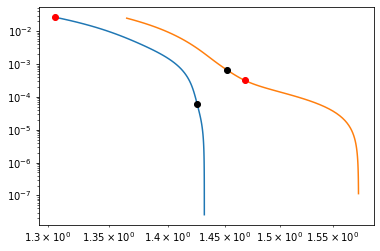

In [19]:
################### DENOISING AND NUMERICAL DIFFERENTIATION - SMOOTHING SPLINES ###################
# Yhat_tik = np.zeros((t_samples, n_states))
# DYhat_tik = np.zeros((t_samples, n_states))
error_X = np.zeros((n_samples,n_states))
trim = int(np.floor(5 / 100 * t_samples))


# for sample in range(n_samples):
for sample in range(1):

    #R code
    for state in range(n_states):
        
        y = Y_samples[state][sample,:]
        
        tik_flc = tikhonov.full_lcurve(y, lambda_min = 100, lambda_max = 10000000000)
        y_path = tik_flc[0]
        res, reg = tik_flc[1]
        error_path = np.zeros(y_path.shape[1])
        for i in range(y_path.shape[1]):
            error_path[i] = norm(y_path[:,i] - X[state,:]) / norm(X[state,:])
        
        min_indx = np.argmin(error_path)
        #Find corner point
        tik_lc = tikhonov.lcurve_corner(y, lambda_min = 100, lambda_max = 10000000000)
        y_tik = tik_lc[0]
        resc, regc = tik_lc[3]
        plt.loglog(res, reg)
        plt.loglog(res[min_indx], reg[min_indx],'ko')
        plt.loglog(resc[-1], regc[-1], 'ro')
#         plt.plot(t, y_path[:,min_indx])
#         plt.plot(t, X[state,:],'k--')
        #Remove ends
        Yhat_tik = y_tik[trim:-trim]
        #Compute errors
        error_X[sample,state] = norm(Yhat_tik - X[state,trim:-trim]) / norm(X[state,trim:-trim])

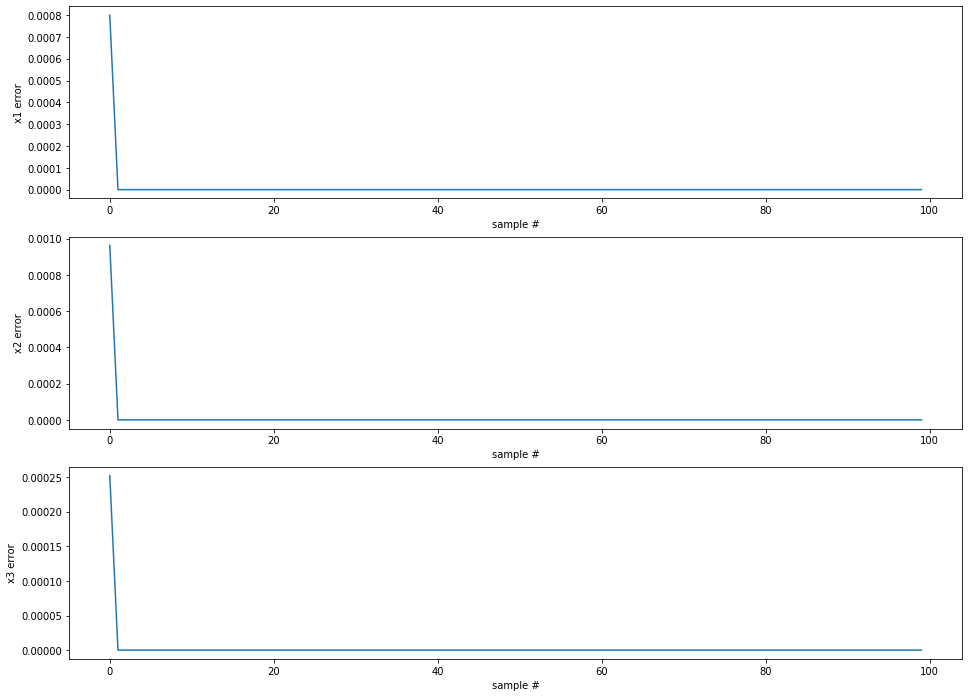

In [27]:
fig, ax = plt.subplots(n_states,1, figsize = (16,12))

for state in range(n_states):
    ax[state].plot(error_X[:,state])
    ax[state].set_ylabel(f'x{state+1} error')
    ax[state].set_xlabel('sample #')

In [28]:
mean_X_error = np.zeros(n_states)
var_X_error = np.zeros(n_states)

ind_names = []
col_names = ['mean error x', 'var. error x']

for state in range(n_states):
    mean_X_error[state] = error_X[:,state].mean()
    var_X_error[state] = error_X[:,state].var()
    ind_names.extend(['state x' + str(state+1)])
    

In [29]:
errors = pd.DataFrame(np.array([mean_X_error, var_X_error]).T, index = ind_names, columns=col_names)
errors

,mean error x,var. error x
state x1,0.000008,6.332284e-09
state x2,0.000010,9.165786e-09
state x3,0.000003,6.297349e-10
